    Ensemble of Models with Better Accuracy

    	Model 1 = EfficientNetB3 = Acc 0.85
	    Model 2 = EfficientNetB4 = Acc 0.85
	    Model 3 = EfficientNetB3 = Acc 0.89
	    Model 4 = EfficientNetB5 = Acc 0.88
	     
       Ensemble of Model 1 + 2 + 3 = Acc 0.86 (Ensemble using majority vote)
       Ensemble of Model 1 + 2 + 3 + 4 = Acc 0.88 (Ensemble using class probability averaging)
	  Ensemble of Model 1 + 2 + 3 + 3 + 4 = Acc 0.87 (Ensemble using weighted average)

In [ ]:
#Checking Memory and GPU availability 

# cheking the number of cpu core this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

# GPU info
!nvidia-smi

# Amount of system RAM available to be used.
from psutil import virtual_memory
ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

#finding recursion limit
import sys
print(sys.getrecursionlimit())

#Installing fastai
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

cpu cores	: 2
Fri May 14 11:32:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [ ]:
#Importing Libraries and Initializing fastai
import numpy as np
import pandas as pd
import time

#Mounting drive to store the model for later use 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate

Mounted at /content/drive


In [ ]:
!pip install --upgrade efficientnet-pytorch
#Importing the Efficient net from pytorch : Original paper implemented in Keras (tpu)
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=4082c416961dea1dab3b0ac0ff954205ed8169680004ecaa1197bfd068907878
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Data Download 
path = untar_data(URLs.FOOD)

train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

#Data Augmentation 
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [ ]:
#Seeding to avoid random pick of data on different models
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
#user defined funtion for performance evaluation
def evaluate_performance(y_true, y_predict):
  """
    y_true    : True labels of the Images in test dataset 
    y_predict : Predicted labels of the images in test dataset 

    prints the Confusion Matrix , No.Of Misclassifications, Recall and Food class with maximum and minimum accuracy 

    Used for performance evaluation of any true and predicted labels
"""
  import sklearn.metrics as metrics
  print(f"{metrics.classification_report(y_true.items, y_predict)}\n")

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  cm1 = confusion_matrix(y_true.items,y_predict)
  print(cm1)

  print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
  print("No.of misclassified samples ", len(y_predict)-sum(cm1.diagonal()))

  #Calculating the True Occurences
  true_occ= []
  for i in range(len(cm1)):
    true_occ.append(sum(cm1[:,i]))

  #Calculating the recall for all the categories
  dia = cm1.diagonal()
  prediction_prob=[]
  for i in range(len(cm1)):
    tmp_prob = dia[i]/true_occ[i]
    prediction_prob.append(tmp_prob)

  incorrect_class = prediction_prob.index(min(prediction_prob))
  correct_class = prediction_prob.index(max(prediction_prob))
  print("Food category with more no.of correct predictions ",y_true.classes[correct_class] )
  print("Food category with min no.of correct predictions ",y_true.classes[incorrect_class] )

In [ ]:
#checking if the valid dataset is the same as other models for ensembling
def crossverify(data_valid_y):
"""
    data_valid_y : labels of the Validation dataset 
    Returns a Boolean value if the validation dataset has the same labels 

    Expecting the same validation data to perform majority vote ensemble
"""
  oop = pd.DataFrame(data_valid_y.items)
  count_valid = oop.value_counts()
  cat_vd = []
  count_vd=[]
  for i in range(101):
    cat_vd.append(i)
    count_vd.append(count_valid[i])
  dict_shift = dict(zip(cat_vd, count_vd))
  count_id = np.array(count_vd)
  if (count_id[0] == 149 and count_id[1]==138 and count_id[2]==150 and count_id[3]==154):
    return True
  else:
    return False

**Model 1 EfficientNetB3 (Accuracy 0.85)**

In [ ]:
#loading EfficientNetB3 model 
bs_mod1 = 16
model = EfficientNet.from_pretrained("efficientnet-b3")	
img_size_mod1 = 512

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=img_size_mod1)
        .databunch(bs=bs_mod1)
        .normalize(imagenet_stats))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


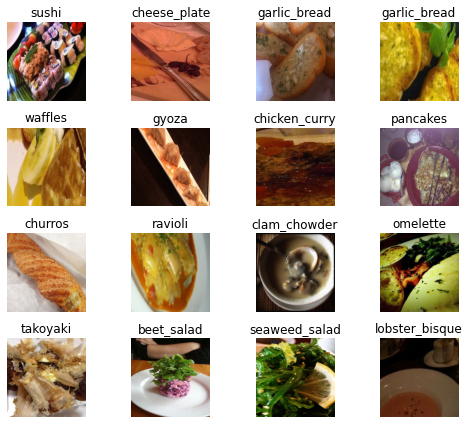

In [ ]:
data.show_batch(rows=8, figsize=(7,6))

In [ ]:
# if crossverify(data.valid_dl.y):
top_5 = partial(top_k_accuracy, k=5)
learn1 = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn1.load('/content/drive/MyDrive/food101-effNetb3-train-e3')

#   start= time.time()
#   Y_valid_predict_mod1 = []
#   for img in data.valid_dl.x:
#       tmp_predict = learn1.predict(img)
#       Y_valid_predict_mod1.append(tmp_predict[2])
#   end = time.time()
#   print({end - start})
# else:
#   print('Different data')

In [ ]:
inter= ClassificationInterpretation.from_learner(learn1)

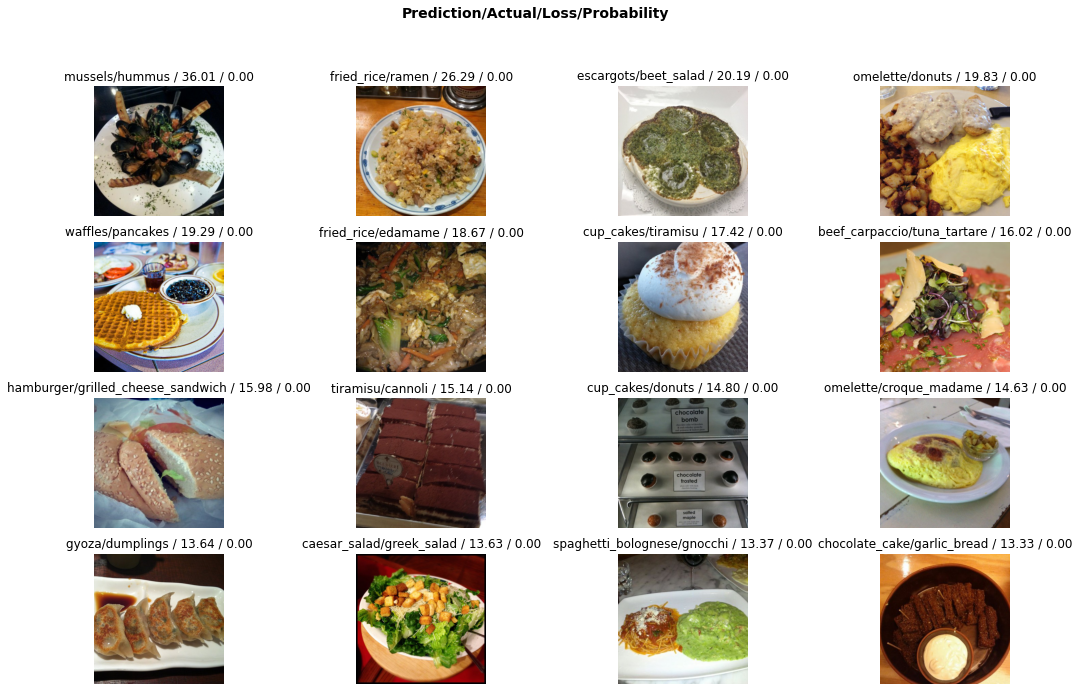

In [ ]:
inter.plot_top_losses(16, figsize=(18, 11))

In [ ]:
#evaluate_performance(data.valid_dl.y,Y_valid_predict_mod1)

**Model 2 - EfficientNetB4 (Accuracy=0.85)**

In [ ]:
#loading EfficientNetB4 model 
if crossverify(data.valid_dl.y):
  model1 = EfficientNet.from_pretrained("efficientnet-b4")	
  top_5 = partial(top_k_accuracy, k=5)
  learn2 = Learner(data, model1, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learn2.load('/content/drive/MyDrive/food-effNetb4101-train-e3')

  start= time.time()
  Y_valid_predict_mod2 = []
  for img in data.valid_dl.x:
      tmp_predict = learn2.predict(img)
      Y_valid_predict_mod2.append(tmp_predict[2])
  end = time.time()
  print({end - start})
else:
  print('Different data')

Loaded pretrained weights for efficientnet-b4


In [ ]:
evaluate_performance(data.valid_dl.y,Y_valid_predict_mod2)

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       149
           1       0.88      0.87      0.88       138
           2       0.91      0.93      0.92       150
           3       0.95      0.93      0.94       154
           4       0.87      0.93      0.90       141
           5       0.91      0.84      0.87       159
           6       0.88      0.92      0.90       133
           7       0.93      0.95      0.94       136
           8       0.84      0.76      0.80       164
           9       0.82      0.87      0.84       136
          10       0.88      0.83      0.85       143
          11       0.89      0.90      0.89       145
          12       0.92      0.91      0.92       157
          13       0.90      0.93      0.91       148
          14       0.94      0.83      0.88       149
          15       0.78      0.84      0.81       148
          16       0.91      0.96      0.94       167
          17       0.83    

**Model 3 - EfficientNetB3 (Accuracy = 0.89)**

In [ ]:
#loading EfficientNetB3 model with accuracy 0.89 
if crossverify(data.valid_dl.y):
  model2 = EfficientNet.from_pretrained("efficientnet-b3")	
  top_5 = partial(top_k_accuracy, k=5)
  learn3 = Learner(data, model2, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learn3.load('/content/drive/MyDrive/food101-effNetb3-train-ev4')

  start= time.time()
  Y_valid_predict_mod3 = []
  for img in data.valid_dl.x:
      tmp_predict = learn3.predict(img)
      Y_valid_predict_mod3.append(tmp_predict[2])
  end = time.time()
  print({end - start})
else:
  print('Different data')

Loaded pretrained weights for efficientnet-b3
{585.1110029220581}


In [ ]:
evaluate_performance(data.valid_dl.y,Y_valid_predict_mod3)

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       149
           1       0.82      0.80      0.81       138
           2       0.86      0.88      0.87       150
           3       0.86      0.90      0.88       154
           4       0.83      0.88      0.86       141
           5       0.89      0.79      0.83       159
           6       0.86      0.90      0.88       133
           7       0.91      0.92      0.91       136
           8       0.74      0.74      0.74       164
           9       0.80      0.81      0.81       136
          10       0.84      0.82      0.83       143
          11       0.85      0.85      0.85       145
          12       0.91      0.89      0.90       157
          13       0.89      0.89      0.89       148
          14       0.84      0.76      0.80       149
          15       0.75      0.76      0.76       148
          16       0.91      0.95      0.93       167
          17       0.81    

**Model 4 - EfficientNetB5**

In [ ]:
if crossverify(data.valid_dl.y):
  model4 = EfficientNet.from_pretrained("efficientnet-b5")	
  top_5 = partial(top_k_accuracy, k=5)
  learn4 = Learner(data, model4, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learn4.load('/content/drive/MyDrive/food101-effNetb5-train-e3')

  # start= time.time()
  # Y_valid_predict_mod4 = []
  # for img in data.valid_dl.x:
  #     tmp_predict = learn4.predict(img)
  #     Y_valid_predict_mod4.append(tmp_predict[2])
  # end = time.time()
  # print({end - start})
else:
  print('Different data')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


**Ensemble Model 1**

In [ ]:
#Ensemble based on majority 
def majority(a,b,c):
"""
    a, b, c : predicted labels from model 1 ,2 3
    Returns a label with majority vote. If a label does not get a majority vote then model 3's label will be returned.

    Note : Keep the model with highest accuracy in c(This will be given high priority compared to the other ones)
"""
  if a==b:
    return c
  elif b ==c:
    return c
  elif a==c:
    return c
  else:
    return c

In [ ]:
y_predict_ensemble=[]
for i in range(len(Y_valid_predict_mod1)):
  y_predict_ensemble.append(majority(Y_valid_predict_mod1[i],Y_valid_predict_mod2[i],Y_valid_predict_mod3[i])) #calling the ensemble model by passing the predicted labels

In [ ]:
#Evaluating the performance of an ensemble model
evaluate_performance(data.valid_dl.y,y_predict_ensemble)

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       149
           1       0.82      0.80      0.81       138
           2       0.86      0.88      0.87       150
           3       0.86      0.90      0.88       154
           4       0.83      0.88      0.86       141
           5       0.89      0.79      0.83       159
           6       0.86      0.90      0.88       133
           7       0.91      0.92      0.91       136
           8       0.74      0.74      0.74       164
           9       0.80      0.81      0.81       136
          10       0.84      0.82      0.83       143
          11       0.85      0.85      0.85       145
          12       0.91      0.89      0.90       157
          13       0.89      0.89      0.89       148
          14       0.84      0.76      0.80       149
          15       0.75      0.76      0.76       148
          16       0.91      0.95      0.93       167
          17       0.81    

**Ensemble Model 2**

In [ ]:
#Ensemble using argmax 
def ensemble_predition(test_img):
"""
    test_img : image from the test / train dataset 
    Returns the predicted label after averaging the probabilities
"""
    img = test_img 
    effb3_predicition = learn1.predict(img) #predict using model1
    effb4_predicition = learn2.predict(img) #predict using model2
    effb31_predicition = learn3.predict(img) #predict using model3
    effb5_predicition = learn4.predict(img) #predict using model4
    
    #ensemble average
    sum_pred = effb3_predicition[2] + effb4_predicition[2] + effb31_predicition[2] + effb5_predicition[2]
    prediction = sum_pred / 4
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    
    return predicted_label


In [ ]:
  #creating ensemble prediction 
  Y_valid_ensemble = []
  for img in data.valid_dl.x:
      tmp_predict = ensemble_predition(img)
      Y_valid_ensemble.append(tmp_predict)

In [ ]:
#Evaluating the performance of ensemble model 2
evaluate_performance(data.valid_dl.y,Y_valid_ensemble)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       149
           1       0.81      0.83      0.82       138
           2       0.90      0.92      0.91       150
           3       0.92      0.92      0.92       154
           4       0.87      0.91      0.89       141
           5       0.90      0.81      0.85       159
           6       0.87      0.92      0.89       133
           7       0.91      0.94      0.93       136
           8       0.78      0.76      0.77       164
           9       0.84      0.85      0.85       136
          10       0.89      0.83      0.86       143
          11       0.88      0.88      0.88       145
          12       0.91      0.90      0.91       157
          13       0.91      0.92      0.92       148
          14       0.88      0.76      0.81       149
          15       0.76      0.80      0.78       148
          16       0.90      0.96      0.93       167
          17       0.84    

In [ ]:
  Y_valid_ensemble2 = []
  for img in data.valid_dl.x:
      tmp_predict = ensemble_predition(img)
      Y_valid_ensemble2.append(tmp_predict)

In [ ]:
evaluate_performance(data.valid_dl.y,Y_valid_ensemble2)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       149
           1       0.83      0.86      0.84       138
           2       0.90      0.91      0.90       150
           3       0.92      0.93      0.93       154
           4       0.87      0.92      0.90       141
           5       0.89      0.85      0.87       159
           6       0.87      0.92      0.89       133
           7       0.91      0.94      0.92       136
           8       0.79      0.78      0.79       164
           9       0.83      0.87      0.85       136
          10       0.86      0.82      0.84       143
          11       0.90      0.89      0.89       145
          12       0.92      0.92      0.92       157
          13       0.92      0.93      0.92       148
          14       0.90      0.77      0.83       149
          15       0.77      0.79      0.78       148
          16       0.91      0.97      0.94       167
          17       0.86    

Ensemble model 3 - Weighted average 

In [ ]:
#Weighted Average 
#Below are the models taken into consideration

# model = EfficientNet.from_pretrained("efficientnet-b3")	- Acc = 0.85 
# learn1.load('/content/drive/MyDrive/food101-effNetb3-train-e3')

# model1 = EfficientNet.from_pretrained("efficientnet-b4") - Acc = 0.85 
# learn2.load('/content/drive/MyDrive/food-effNetb4101-train-e3')

# model2 = EfficientNet.from_pretrained("efficientnet-b3") - Acc = 0.89
# learn3.load('/content/drive/MyDrive/food101-effNetb3-train-ev4')

# model4 = EfficientNet.from_pretrained("efficientnet-b5") - Acc = 0.85
# learn4.load('/content/drive/MyDrive/food101-effNetb5-train-e3')

# model5 = EfficientNet.from_pretrained("efficientnet-b3") - Acc = 0.89
# learn5.load('/content/drive/MyDrive/food101-effNetb3-train-ev4')

# The model with most accuracy 0.89 is repeated twice to increase the weight.

In [ ]:
def ensemble_predition2(test_img):
"""
    test_img : image from the test / train dataset 
    Returns the predicted label after weighted average of the probabilities
""" 
    img = test_img 
    effb3_predicition = learn1.predict(img)
    effb4_predicition = learn2.predict(img)
    effb31_predicition = learn3.predict(img)
    effb5_predicition = learn4.predict(img)
    effb312_predicition = learn3.predict(img)
    
    #ensemble average
    sum_pred = effb3_predicition[2] + effb4_predicition[2] + effb31_predicition[2] + effb5_predicition[2]+effb312_predicition[2]
    prediction = sum_pred / 5
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    
    return predicted_label

In [ ]:
  Y_valid_ensemble3 = []
  for img in data.valid_dl.x:
      tmp_predict = ensemble_predition2(img)
      Y_valid_ensemble3.append(tmp_predict)

In [ ]:
#evaluating the performance of ensemble 3
evaluate_performance(data.valid_dl.y,Y_valid_ensemble3)

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       149
           1       0.83      0.83      0.83       138
           2       0.88      0.91      0.89       150
           3       0.89      0.92      0.90       154
           4       0.85      0.91      0.88       141
           5       0.89      0.82      0.85       159
           6       0.87      0.92      0.90       133
           7       0.90      0.93      0.92       136
           8       0.78      0.77      0.78       164
           9       0.84      0.87      0.86       136
          10       0.86      0.83      0.84       143
          11       0.88      0.88      0.88       145
          12       0.91      0.91      0.91       157
          13       0.92      0.93      0.92       148
          14       0.90      0.77      0.83       149
          15       0.76      0.79      0.78       148
          16       0.91      0.97      0.94       167
          17       0.85    